In [ ]:
print("hola mundo")

hola mundo


## **Importación de bibliotecas**

A continuación, se describen las bibliotecas utilizadas en el desarrollo del modelo:

- **os**: Permite interactuar con el sistema operativo, útil para manejar archivos y directorios en la carga de datos.
- **torch**: Librería principal de PyTorch para el desarrollo y entrenamiento de modelos de aprendizaje profundo.
- **torch.nn**: Proporciona módulos y funciones para construir redes neuronales en PyTorch.
- **torch.optim**: Contiene optimizadores utilizados para entrenar modelos mediante descenso de gradiente.
- **pandas**: Se utiliza para manipulación y análisis de datos tabulares, como la carga de etiquetas desde archivos CSV.
- **torchvision.transforms**: Ofrece transformaciones para preprocesar imágenes antes de ingresarlas al modelo.
- **PIL (Python Imaging Library)**: Se usa para cargar y manipular imágenes en diferentes formatos.
- **torch.utils.data (Dataset y DataLoader)**: Facilita la gestión de los conjuntos de datos y su alimentación al modelo en lotes.
- **itertools**: Proporciona herramientas para iteraciones eficientes, útil para combinaciones o permutaciones de datos.
- **torchvision.models (efficientnet_v2_s)**: Se importa el modelo preentrenado EfficientNetV2-S, que se usará como base para la clasificación.
- **torch.nn.functional**: Contiene funciones útiles como activaciones, pérdidas y operaciones sobre tensores.

### **Uso en el notebook**
Estas bibliotecas permiten construir un pipeline de aprendizaje profundo que incluye:
1. **Carga y preprocesamiento de datos**: Se usa `os`, `pandas`, `PIL`, y `torchvision.transforms` para leer imágenes y etiquetas.
2. **Definición del modelo**: Se emplea `torch.nn` y `efficientnet_v2_s` para crear la red neuronal.
3. **Entrenamiento**: `torch.optim` y `torch.nn.functional` ayudan a definir el proceso de optimización y la función de pérdida.
4. **Evaluación y predicción**: Se aplican las herramientas de PyTorch para evaluar el modelo y generar predicciones sobre datos de prueba.

---


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision.models import efficientnet_v2_s
import torch.nn.functional as F

## **Carga y organización de datos**

En esta sección, organizamos los conjuntos de datos para entrenamiento, validación y prueba.  
Los datos provienen del desafío **BreastPathQ 2019** y están estructurados en imágenes de parches histológicos junto con sus etiquetas.

### **1️ Directorios de imágenes**
- **`train_image_dir`**: Contiene las imágenes de entrenamiento con sus etiquetas.
- **`val_image_dir`**: Contiene las imágenes de validación con sus etiquetas.
- **`test_image_dir`**: Contiene las imágenes de prueba (sin etiquetas).

### **2️ Rutas de etiquetas**
- **`train_label_path`**: Archivo CSV con etiquetas de entrenamiento.
- **`val_label_path`**: Archivo CSV con etiquetas de validación.

---

## **Procesamiento de los conjuntos de datos**

1. **Entrenamiento (`df_train`)**
   - Se carga el CSV de entrenamiento.
   - Se genera el nombre de cada imagen combinando `slide` y `rid`.
  
2. **Validación (`df_val`)**
   - Se listan todas las imágenes del directorio de validación.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - Se unen estos datos con el CSV de etiquetas.

3. **Prueba (`df_test`)**
   - Se listan todas las imágenes del directorio de prueba.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - **(Importante)** No hay etiquetas en este conjunto.

---

## **Diagrama de distribución de imagenes en los conjuntos de datos**
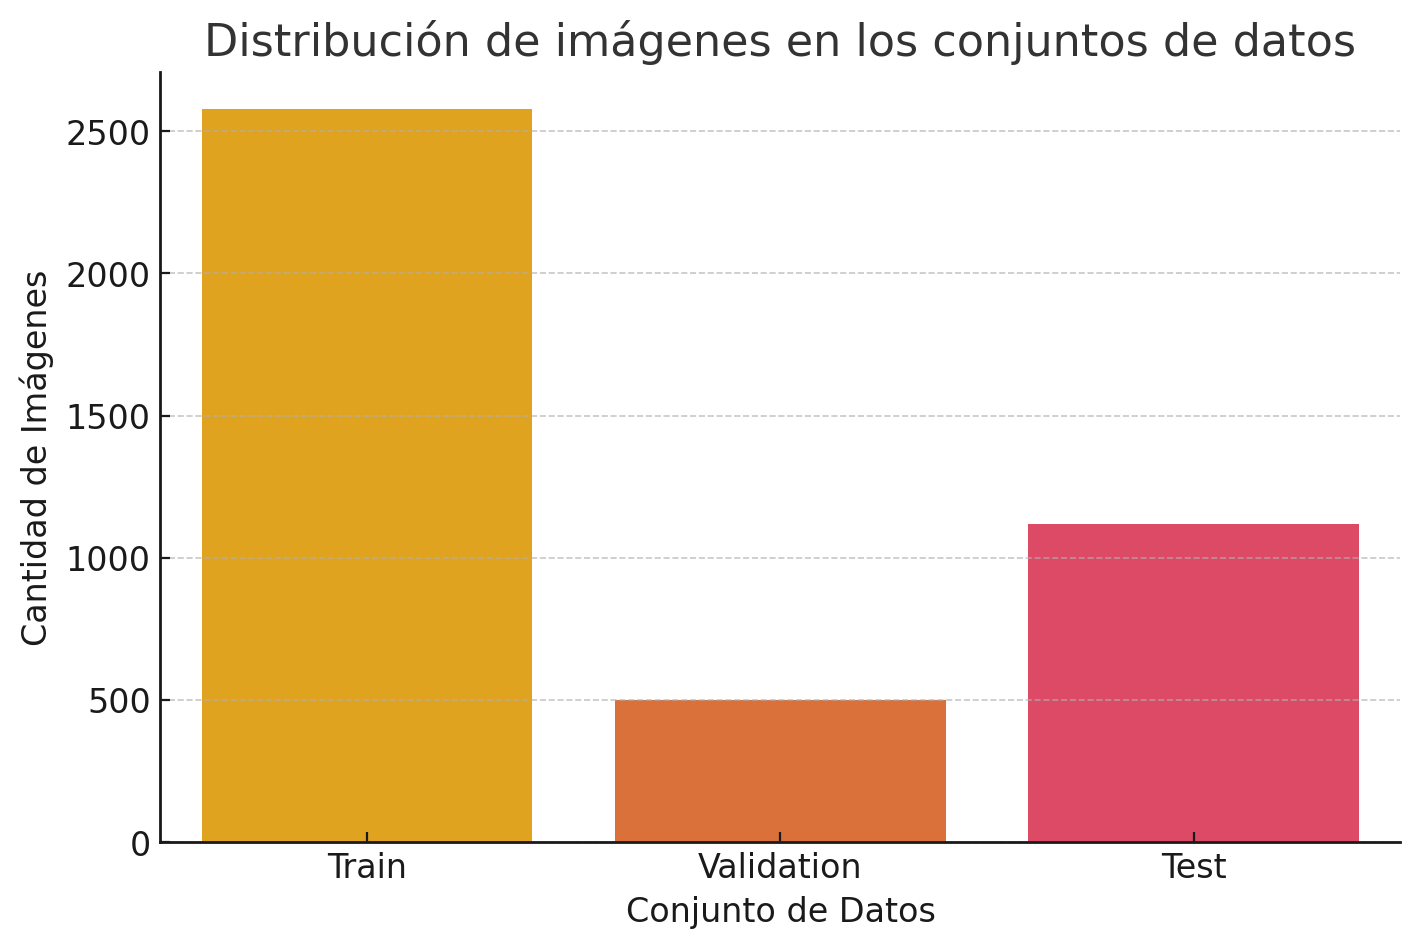


---


In [ ]:
# Directorios de imágenes
train_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train"
val_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/validation"
test_image_dir = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/test_patches"

# Rutas de etiquetas
train_label_path = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train_labels.csv"
val_label_path = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/val_labels.csv"

# Cargar datos
df_train = pd.read_csv(train_label_path)
df_train["image_name"] = df_train["slide"].astype(str) + "_" + df_train["rid"].astype(str) + ".tif"

val_images = [f for f in os.listdir(val_image_dir) if f.endswith(".tif")]
df_val = pd.DataFrame({"image_name": val_images})
df_val[["slide", "rid"]] = df_val["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)
df_val_labels = pd.read_csv(val_label_path)
df_val = df_val.merge(df_val_labels, on=["slide", "rid"], how="left")

test_images = [f for f in os.listdir(test_image_dir) if f.endswith(".tif")]
df_test = pd.DataFrame({"image_name": test_images})
df_test[["slide", "rid"]] = df_test["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)

# Resumen de conjuntos de datos
print("Organización Final de Conjuntos:")
print(f"Train: {len(df_train)} imágenes")
print(f"Validation: {len(df_val)} imágenes")
print(f"Test_patches: {len(df_test)} imágenes (Debe ser 1119)")


Organización Final de Conjuntos:
Train: 2394 imágenes
Validation: 185 imágenes
Test_patches: 1119 imágenes (Debe ser 1119)


In [ ]:
class BreastDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_test=False):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image_name"]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]["y"]
            return image, torch.tensor(label, dtype=torch.float32)

# Transformaciones para EfficientNetV2
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets y dataloaders
train_dataset = BreastDataset(df_train, train_image_dir, transform)
val_dataset = BreastDataset(df_val, val_image_dir, transform)
test_dataset = BreastDataset(df_test, test_image_dir, transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📌 Dispositivo en uso: {device}")

efficientnet = efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_ftrs, 1)  # Modificar la capa final para regresión
efficientnet = efficientnet.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.0008)


📌 Dispositivo en uso: cuda


In [ ]:
epochs = 50  # Ajustamos a 50 ya que EfficientNetV2 aprende más rápido
for epoch in range(epochs):
    efficientnet.train()
    epoch_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"📌 Época {epoch+1}/{epochs} - Pérdida: {epoch_loss/len(train_loader):.4f}")


📌 Época 1/50 - Pérdida: 0.0424
📌 Época 2/50 - Pérdida: 0.0176
📌 Época 3/50 - Pérdida: 0.0123
📌 Época 4/50 - Pérdida: 0.0099
📌 Época 5/50 - Pérdida: 0.0085
📌 Época 6/50 - Pérdida: 0.0064
📌 Época 7/50 - Pérdida: 0.0055
📌 Época 8/50 - Pérdida: 0.0054
📌 Época 9/50 - Pérdida: 0.0052
📌 Época 10/50 - Pérdida: 0.0041
📌 Época 11/50 - Pérdida: 0.0036
📌 Época 12/50 - Pérdida: 0.0037
📌 Época 13/50 - Pérdida: 0.0049
📌 Época 14/50 - Pérdida: 0.0054
📌 Época 15/50 - Pérdida: 0.0046
📌 Época 16/50 - Pérdida: 0.0033
📌 Época 17/50 - Pérdida: 0.0025
📌 Época 18/50 - Pérdida: 0.0023
📌 Época 19/50 - Pérdida: 0.0022
📌 Época 20/50 - Pérdida: 0.0022
📌 Época 21/50 - Pérdida: 0.0041
📌 Época 22/50 - Pérdida: 0.0118
📌 Época 23/50 - Pérdida: 0.0106
📌 Época 24/50 - Pérdida: 0.0056
📌 Época 25/50 - Pérdida: 0.0041
📌 Época 26/50 - Pérdida: 0.0028
📌 Época 27/50 - Pérdida: 0.0026
📌 Época 28/50 - Pérdida: 0.0027
📌 Época 29/50 - Pérdida: 0.0022
📌 Época 30/50 - Pérdida: 0.0019
📌 Época 31/50 - Pérdida: 0.0019
📌 Época 32/50 - P

In [ ]:
efficientnet.eval()
test_predictions = []

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = efficientnet(images).squeeze().cpu().numpy()
        outputs = F.sigmoid(torch.tensor(outputs)).numpy()  # Convertir a [0,1]

        for img_name, pred in zip(image_names, outputs):
            slide, rid = img_name.replace(".tif", "").split("_")
            test_predictions.append([int(slide), int(rid), pred])

df_test_predictions = pd.DataFrame(test_predictions, columns=["slide", "rid", "score"])
df_test_predictions.to_csv("submission_test.csv", index=False)

print(f"✅ Archivo de predicciones generado: submission_test.csv")


✅ Archivo de predicciones generado: submission_test.csv


In [ ]:
def calculate_pk(labels, predictions):
    P, Q, T = 0, 0, 0
    for (pred_i, true_i), (pred_j, true_j) in itertools.combinations(zip(predictions, labels), 2):
        if (true_i < true_j and pred_i < pred_j) or (true_i > true_j and pred_i > pred_j):
            P += 1
        elif (true_i < true_j and pred_i > pred_j) or (true_i > true_j and pred_i < pred_j):
            Q += 1
        elif pred_i == pred_j:
            T += 1
    return (((P - Q) / (P + Q + T)) + 1) / 2 if (P + Q + T) != 0 else 0

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    all_labels, all_predictions = [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    pk = calculate_pk(all_labels, all_predictions)
    print(f"📌 PK Score: {pk:.4f}")

evaluate_model(efficientnet, val_loader, criterion, device)


📌 PK Score: 0.9085
